# BÁO CÁO BÀI TẬP THỰC HÀNH VÀ ĐỒ ÁN CUỐI KỲ


In [1]:
# import các thư viện
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split
from collections import Counter
from IPython.display import display
from tqdm import tqdm
import cv2

In [2]:
# Các biến toàn cục

# thư mục gốc chứa thư mục dữ liệu
szWorkingDir = "/kaggle/input/car-cs114"

# dùng để hiển thị
nNumImgsPerRow = 10
nImgHeight = nImgWidth = 150

In [3]:
# mapping
labels = {
    'Others': 0,
    'Honda': 1,
    'Hyundai': 2,
    'KIA': 3,
    'Mazda': 4,
    'Mitsubishi': 5,
    'Suzuki': 6,
    'Toyota': 7,
    'VinFast': 8
}
reverse_map_labels = {
    0: 'Others',
    1: 'Honda',
    2: 'Hyundai',
    3: 'KIA',
    4: 'Mazda',
    5: 'Mitsubishi',
    6: 'Suzuki',
    7: 'Toyota',
    8: 'VinFast'
}

Đoạn mã bao gồm:

* File csv chứa ảnh lỗi: Không thể đọc được
* File csv chứa thông tin kênh màu, độ trong suốt
* File csv chứa thông tin các ảnh trùng được phát hiện thông qua bài tập Clustering (trong phần này là tập Train-1)
* Và đường dẫn dataset và train-1.csv

In [4]:
path_img = os.path.join(szWorkingDir, "dataset")
error = pd.read_csv(os.path.join(szWorkingDir,"ImageErrors.csv"))
error_paths = error.iloc[:, 0].unique().tolist() # Lấy thông tin đường dẫn ảnh lỗi

In [5]:
csv_dir = os.path.join(szWorkingDir,"car_split/car_split")
#link test
img_path_test =os.path.join(csv_dir,"CarDataset-Splits-5-Test.csv")
#Đọc File test
dataTest = pd.read_csv(img_path_test)
dataTest

ImageFullPath  CategoryID
0               Others/22520394-22520395.Others.578.jpg           0
1               Others/22521586-22521559.Others.189.jpg           0
2      Others/22521027-22520195-22521060.Others.443.jpg           0
3               Others/22520779-22521587.Others.716.jpg           0
4       Others/22521027-22520195-22521060.Others.50.jpg           0
...                                                 ...         ...
7338  VinFast/22520683-22520811-22521465.VinFast.27.jpg           8
7339  VinFast/22521027-22520195-22521060.VinFast.115...           8
7340            VinFast/22521560-22521614.VinFast.4.jpg           8
7341          VinFast/22521070-22520211.VinFast.185.jpg           8
7342  VinFast/22521027-22520195-22521060.VinFast.090...           8

[7343 rows x 2 columns]

In [6]:
dataTest = dataTest[~dataTest['ImageFullPath'].isin(error_paths)]
dataTest

ImageFullPath  CategoryID
0               Others/22520394-22520395.Others.578.jpg           0
1               Others/22521586-22521559.Others.189.jpg           0
2      Others/22521027-22520195-22521060.Others.443.jpg           0
3               Others/22520779-22521587.Others.716.jpg           0
4       Others/22521027-22520195-22521060.Others.50.jpg           0
...                                                 ...         ...
7338  VinFast/22520683-22520811-22521465.VinFast.27.jpg           8
7339  VinFast/22521027-22520195-22521060.VinFast.115...           8
7340            VinFast/22521560-22521614.VinFast.4.jpg           8
7341          VinFast/22521070-22520211.VinFast.185.jpg           8
7342  VinFast/22521027-22520195-22521060.VinFast.090...           8

[7334 rows x 2 columns]

In [7]:
img = dataTest['ImageFullPath']
test_label = dataTest['CategoryID']
test_image = [os.path.join(path_img, i) for i in img]
len(test_image)

7334

Dùng để hiển thị

* nNumImgsPerRow = 10
* nImgHeight = nImgWidth = 150

In [8]:
# Số lượng các danh mục hoặc lớp ảnh khác nhau
classes = 9

# Kích thước của mỗi ảnh trong hình
figsize_per_image = (2, 2)

def display_images(data):

    images = {}

    # Lặp qua từng lớp
    for Class in range(classes):
        # Lọc dataframe theo lớp hiện tại
        class_df = data[data['CategoryID'] == Class]

        # Lấy ngẫu nhiên các đường dẫn ảnh từ dataframe đã lọc
        sample_images = class_df.sample(n=min(nNumImgsPerRow, len(class_df)))['ImageFullPath']

        # Tải và thay đổi kích thước từng ảnh được chọn, lưu vào dictionary `images`
        images[Class] = [cv2.resize(cv2.imread(os.path.join(path_img, img_path), cv2.IMREAD_COLOR), (nImgWidth, nImgHeight)) for img_path in sample_images]

    # Tính toán kích thước hình dựa trên số lượng ảnh và số lớp
    figsize = (figsize_per_image[0] * (nNumImgsPerRow + 1), figsize_per_image[1] * classes)

    # Tạo các ô con (subplot) với số dòng là số lớp và số cột là `NumImgsPerRow + 1`
    fig, axes = plt.subplots(classes, nNumImgsPerRow + 1, figsize=figsize)

    # Hiển thị ảnh
    for i in tqdm(range(classes)):
        for j in range(nNumImgsPerRow + 1):
            # Lấy ô subplot hiện tại
            ax = axes[i, j]

            # Nếu là cột đầu tiên, hiển thị nhãn lớp
            if j == 0:
                ax.text(0.5, 0.5, f'{reverse_map_labels[i]}', va='center', ha='center', transform=ax.transAxes, fontsize=14, fontweight='bold')
            # Nếu không, hiển thị ảnh nếu tồn tại
            elif j-1 < len(images[i]):
                ax.imshow(cv2.cvtColor(images[i][j-1], cv2.COLOR_BGR2RGB))

            # Ẩn các đường viền trục để giao diện gọn gàng hơn
            ax.axis('off')

    # Điều chỉnh bố cục để tránh chồng lấn và hiển thị hình
    plt.tight_layout()
    plt.show()

100%|██████████| 9/9 [00:00<00:00, 113.94it/s]


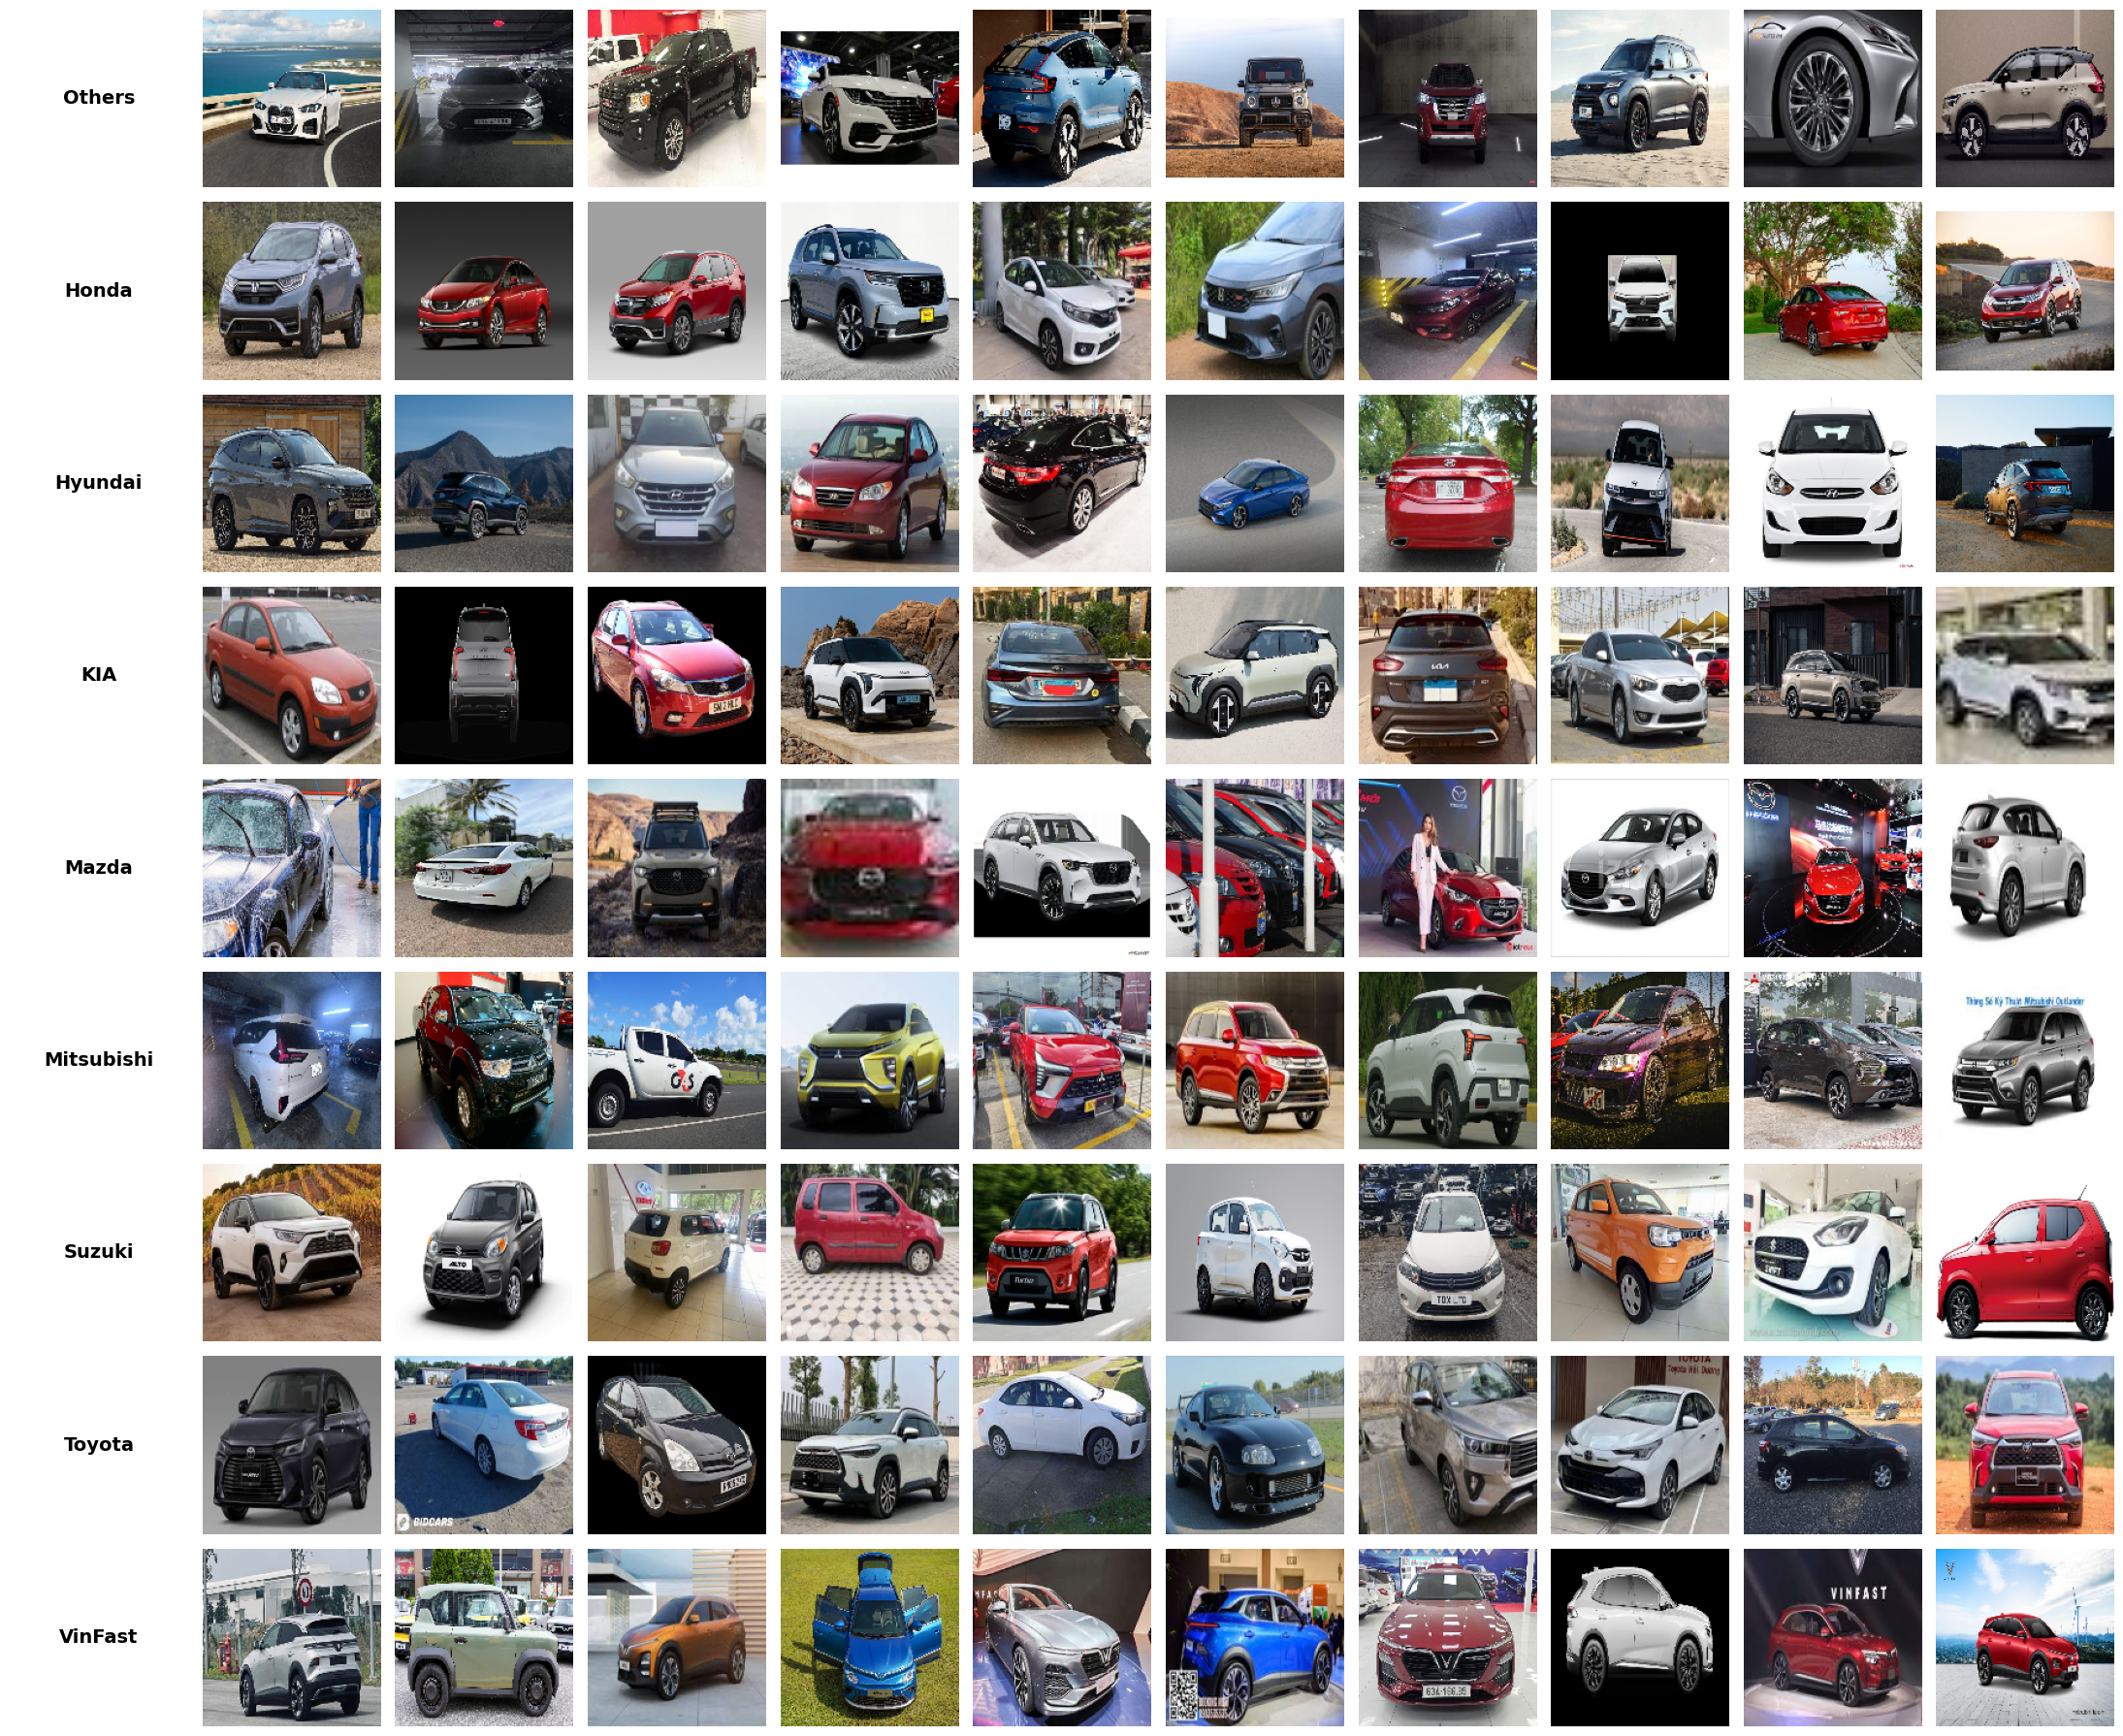

In [9]:
display_images(dataTest)

In [10]:
data_transforms = {
    'test': transforms.Compose([
        transforms.Lambda(lambda img: img.convert('RGB') if img.mode != 'RGB' else img),  # Thêm bước chuyển đổi sang RGB
        transforms.Resize(384, interpolation=Image.BICUBIC),  # Thay đổi kích thước ảnh thành 224x224
        transforms.CenterCrop(384),  # Cắt ảnh từ giữa để có kích thước 224x224
        transforms.ToTensor(),  # Chuyển ảnh từ định dạng PIL sang tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Chuẩn hóa ảnh dựa trên thông số của ImageNet
    ]),
}

In [11]:
class CustomDataset(Dataset):
    def __init__(self, img_paths, labels, transform=None):
        self.img_paths = img_paths
        self.labels = np.array(labels)
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        label = self.labels[idx]

        # Mở ảnh bằng Pillow
        img_pil = Image.open(img_path)
        # Chuyển đổi sang RGB nếu không phải
        if img_pil.mode != 'RGB':
            img_pil = img_pil.convert('RGB')

        # Áp dụng các phép biến đổi
        if self.transform:
            img_pil = self.transform(img_pil)

        return img_pil, label

In [12]:
test_set = CustomDataset(test_image,test_label, transform=data_transforms['test'])

test_loader = DataLoader(test_set, batch_size=32, shuffle=False,pin_memory=True,num_workers= 4)

### Bước 4 - Model Configuration

- Có thể chọn Logistic Regression

In [13]:
from tempfile import TemporaryDirectory
import torch.optim as optim
import time
import torchvision.models as models
from torch.optim import lr_scheduler

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [15]:
import torch
# Kiểm tra GPU memory trước khi load model
print(f"GPU memory before model: {torch.cuda.memory_allocated()/1e9:.2f} GB")
torch.cuda.empty_cache()

GPU memory before model: 0.00 GB


In [16]:
from torchvision.models import regnet_y_128gf, RegNet_Y_128GF_Weights

weights = RegNet_Y_128GF_Weights.IMAGENET1K_SWAG_E2E_V1  # Dùng E2E đúng yêu cầu
model_ft = regnet_y_128gf(weights=weights)

# Unfreeze the last few layers
for param in model_ft.parameters():
    param.requires_grad = False

# Unfreeze the last block and the final fully connected layer
for param in model_ft.trunk_output.block4.parameters():
    param.requires_grad = True

# Replace the last fully connected layer with a new one
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Sequential(
    nn.Linear(num_ftrs, 1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 9)  # Assuming you have 9 classes
)

# Move model to device (GPU if available)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_ft = model_ft.to(device)

Downloading: "https://download.pytorch.org/models/regnet_y_128gf_swag-c8ce3e52.pth" to /root/.cache/torch/hub/checkpoints/regnet_y_128gf_swag-c8ce3e52.pth
100%|██████████| 2.40G/2.40G [00:12<00:00, 199MB/s]


reverse_map_labels = {

    0: 'Others',
    1: 'Honda',
    2: 'Hyundai',
    3: 'KIA',
    4: 'Mazda',
    5: 'Mitsubishi',
    6: 'Suzuki',
    7: 'Toyota',
    8: 'VinFast'
    
}

<ipython-input-17-b44536904971>:89: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_ft.load_state_dict(torch.load('/kaggle/input/regnet-tune/regnet_e2e_tune_03.pt'))
/us

Test Accuracy: 0.8814


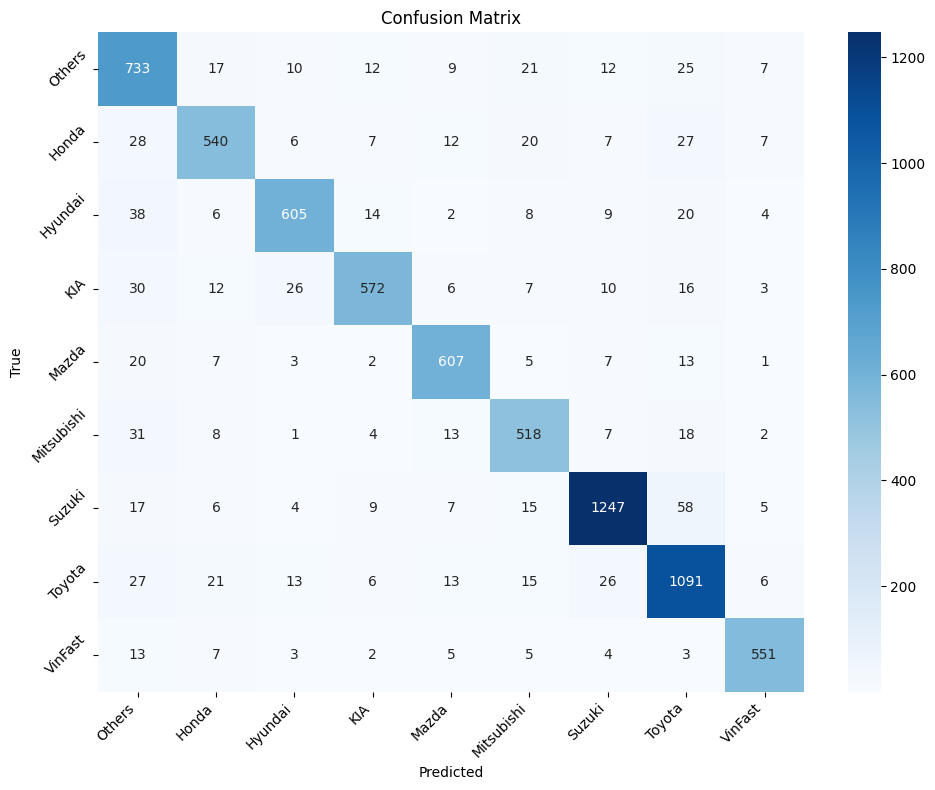

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


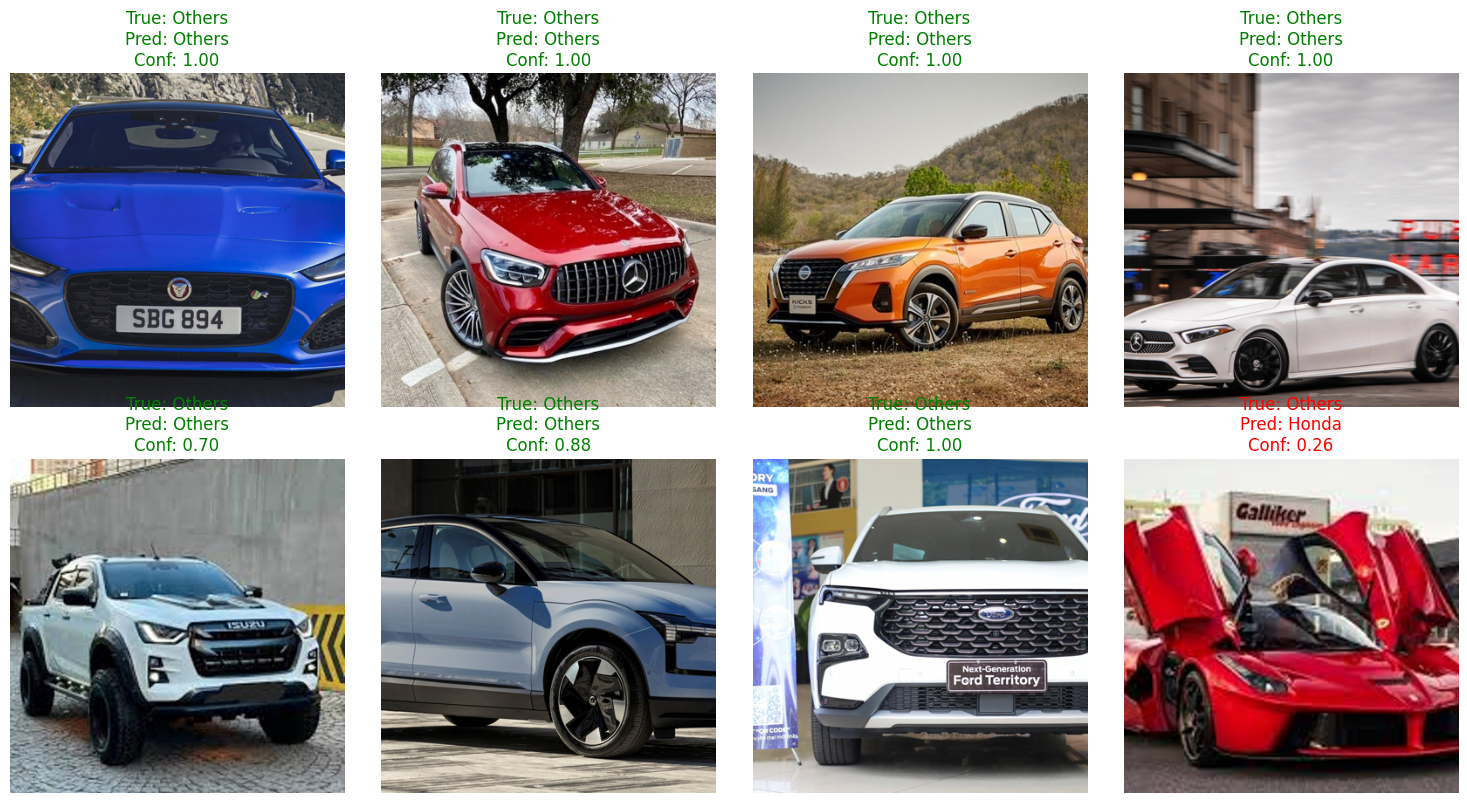

In [17]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

# Lấy list tên các hãng xe theo thứ tự index
class_names = [reverse_map_labels[i] for i in range(len(reverse_map_labels))]

def evaluate_and_visualize(model, test_loader, device, num_images=8):
    model.eval()
    all_predictions = []
    all_labels = []
    
    # Tính accuracy và confusion matrix
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_predictions.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Hiển thị accuracy
    accuracy = accuracy_score(all_labels, all_predictions)
    print(f'Test Accuracy: {accuracy:.4f}')
    
    # Vẽ confusion matrix
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(all_labels, all_predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    # Hiển thị một số ảnh và dự đoán
    dataiter = iter(test_loader)
    images, labels = next(dataiter)
    images = images.to(device)
    labels = labels.to(device)
    
    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        probs = torch.nn.functional.softmax(outputs, dim=1)
    
    # Tạo lưới ảnh
    fig = plt.figure(figsize=(15, 8))
    num_images = min(num_images, len(images))
    
    for idx in range(num_images):
        ax = plt.subplot(2, 4, idx + 1)
        
        # Chuyển đổi tensor thành ảnh
        img = images[idx].cpu()
        # Đảo ngược normalize transform
        inv_normalize = transforms.Normalize(
            mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
            std=[1/0.229, 1/0.224, 1/0.225]
        )
        img = inv_normalize(img)
        img = img.permute(1, 2, 0).numpy()
        img = np.clip(img, 0, 1)
        
        plt.imshow(img)
        
        # Lấy nhãn thật và dự đoán
        true_idx = labels[idx].cpu().item()
        pred_idx = preds[idx].cpu().item()
        true_label = reverse_map_labels[true_idx]
        pred_label = reverse_map_labels[pred_idx]
        prob = probs[idx][pred_idx].cpu().item()
        
        # Màu cho tiêu đề dựa trên dự đoán đúng/sai
        color = 'green' if pred_idx == true_idx else 'red'
        
        title = f'True: {true_label}\nPred: {pred_label}\nConf: {prob:.2f}'
        plt.title(title, color=color)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Load model
model_ft.load_state_dict(torch.load('/kaggle/input/regnet-tune/regnet_e2e_tune_03.pt'))
model_ft = model_ft.to(device)
evaluate_and_visualize(model_ft, test_loader, device)